In [62]:
from pathlib import Path
import matplotlib as mpl
import xarray as xr

In [63]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

In [64]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [65]:
from bs_fdbck.constants import path_measurement_data
select_station = 'ATTO'
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'

In [66]:
fn_obs_comb_data_full_time =postproc_data_obs /'ATTO_data_comb_hourly.nc'

In [67]:
plot_path = Path(f'Plots/{select_station}')

In [68]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalNx_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

In [69]:
plot_path.mkdir(exist_ok=True, parents=True)

## Read in model data. 

In [70]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [71]:
from bs_fdbck.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
import numpy as np

In [74]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

# Functions:

In [75]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [76]:
model_lev_i=-3

In [77]:
import pandas as pd

## Read in model data

In [78]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        if model_lev_i !=-2:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}_ilev{model_lev_i}.csv'
        else:
            fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'

        #fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback_ilev-3.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp_ilev-3.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara_ilev-3.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_UKESM_AEROCOMTRAJ_ilev-3.csv


In [79]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200','N50-500','N100-500','N200-500']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

### Calculate Nx-500:


In [80]:
for mod in models:
    print(mod)
    for ca in dic_df_pre[mod].keys():
        print(ca)
        _df = dic_df_pre[mod][ca]
        for v in ['N50','N100','N200']:
            _df[f'{v}-500'] = _df[v] -_df['N500'] 
        dic_df_pre[mod][ca] = _df

ECHAM-SALSA
SALSA_BSOA_feedback
NorESM
OsloAero_intBVOC_f09_f09_mg17_fssp
EC-Earth
ECE3_output_Sara
UKESM
AEROCOMTRAJ


## Read in observations

In [81]:
ds_obs = xr.open_dataset(fn_obs_comb_data_full_time, engine='netcdf4')

In [82]:
ds_obs = ds_obs.sel(time_traj=0)

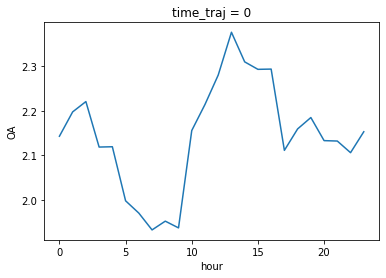

In [83]:
ds_obs['OA'].groupby(ds_obs['time.hour']).median().plot()

In [84]:
varl = [
    #'pnsd',
 'Pressure_reanalysis',
 'Potential_Temperature_reanalysis',
 'Temperature_reanalysis',
 'Rainfall',
 'Mixing_Depth',
 'Relative_Humidity',
 'Specific_Humidity_reanalysis',
 'Mixing_Ratio',
 #'Terrain_Altitude',
 'Solar_Radiation',
 #'x',
 #'y',
 #'z',
 'condensation_sink',
 #'pnsd_nolog',
 'N50-500',
 'N100-500',
 'N200-500',
 'timeUTC-3',
 #'hour',
 'pressure',
 'temperature',
 'humidity',
 #'wind_dir',
 'precip',
 #'Solar_inc_Wm2',
 #'Solar_out_Wm2',
 #'wind_speed',
 #'wind_speed_v',
 'OA'
]
ds_obs[varl].squeeze().to_dataframe()

,Pressure_reanalysis,Potential_Temperature_reanalysis,Temperature_reanalysis,Rainfall,Mixing_Depth,Relative_Humidity,Specific_Humidity_reanalysis,Mixing_Ratio,Solar_Radiation,condensation_sink,N50-500,N100-500,N200-500,timeUTC-3,pressure,temperature,humidity,precip,OA,time_traj
time,,,,,,,,,,,,,,,,,,,,
2014-03-10 15:00:00,974.8,305.5,303.3,0.0,1437.6,55.1,15.1,15.4,681.2,0.001503,316.350342,259.764876,123.407339,2014-03-10 16:00:00,986.86,31.46,57.56,0.0,0.990,0
2014-03-10 16:00:00,974.1,305.5,303.2,0.0,1268.8,56.0,15.2,15.6,596.6,0.001285,288.441016,221.149397,102.265441,2014-03-10 17:00:00,986.21,31.62,59.16,0.0,1.620,0
2014-03-10 17:00:00,974.9,304.5,302.3,0.0,863.0,60.5,15.6,16.0,504.7,0.001317,294.872421,223.659092,104.508354,2014-03-10 18:00:00,986.25,30.01,66.29,0.0,1.660,0
2014-03-10 18:00:00,975.8,303.5,301.4,0.0,453.1,65.1,15.9,16.3,412.7,0.001469,323.442362,243.316332,120.456843,2014-03-10 19:00:00,986.47,28.18,70.54,0.0,0.985,0
2014-03-10 19:00:00,976.6,302.5,300.5,0.0,43.2,69.7,16.1,16.6,320.7,0.001441,323.533283,236.004666,116.970997,2014-03-10 20:00:00,987.01,27.40,82.67,0.0,2.420,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-28 05:00:00,979.4,298.0,296.2,0.0,254.7,85.8,15.3,15.7,18.9,0.000014,2.886702,2.418678,1.160755,2019-01-28 06:00:00,NaN,NaN,NaN,NaN,NaN,0
2019-01-28 06:00:00,980.0,297.9,296.2,0.0,363.3,88.0,15.7,16.1,38.1,0.000013,2.189876,2.165097,1.267096,2019-01-28 07:00:00,NaN,NaN,NaN,NaN,NaN,0
2019-01-28 07:00:00,980.7,297.8,296.1,0.0,472.0,90.2,16.0,16.4,57.4,0.000011,2.075599,1.882887,0.938360,2019-01-28 08:00:00,NaN,NaN,NaN,NaN,NaN,0


In [85]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = ds_obs[varl].squeeze().to_dataframe()
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [86]:
mod2cases['Observations']= ['Observations']

## Set uo dic with all OA values from models

In [87]:
dic_df_mod_case = dic_df_pre

## Merge with observations:

In [88]:
dic_df_mod_case = dic_df_pre.copy()

In [89]:
mask_obs_OA =  dic_df_pre['Observations']['Observations']['N100-500'].notnull()

In [90]:
_df = dic_df_pre['Observations']['Observations']['OA'].rename('Obs')

df_OA_all = pd.DataFrame(_df)
df_OAG_all = pd.DataFrame(_df)

In [91]:
varl_Nx = ['N50-500','N100-500','N200-500']

In [92]:
dic_Nx=dict()

for v in varl_Nx:
    _df = dic_df_pre['Observations']['Observations'][v].rename('Obs')

    df_Nx_all = pd.DataFrame(_df)
    
    for mod in dic_df_pre.keys():
        if mod=='Observations':
            continue
        print(mod)
        for ca in dic_df_pre[mod].keys():
            if len(dic_df_pre[mod].keys())==1:
                use_name = mod
            else: 
                use_name = f'{mod}: {ca}'
            df_Nx_all[use_name] = dic_df_pre[mod][ca][v]


    df_Nx_all = df_Nx_all[df_Nx_all['Obs'].notna()]
    dic_Nx[v] = df_Nx_all.copy()



ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
NorESM
EC-Earth
UKESM


In [93]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [94]:
seasons2months = {'DJF':[12,1,2],
        'MAM': [3,4,5],
        'JJA':[6,7,8],
        'SON':[9,10,11],
       }

In [95]:
seasons2months2 = {'JFM': [ 1, 2,3], 'AMJ': [ 4, 5,6], 'JAS': [ 7, 8,9], 'OND': [ 10, 11,12]}

### Calculate anomaly from daily average

In [96]:
dic_anom_Nx = dict()
for v in dic_Nx.keys():
    _df_Nx_all = dic_Nx[v].copy()
    df_anom_Nx = _df_Nx_all-_df_Nx_all.resample('D').mean().resample('h').ffill(limit=24)
    dic_anom_Nx[v] = df_anom_Nx[df_anom_Nx['Obs'].notna()]



In [97]:
linestyle_dic = {
    'Obs': 'solid',
    'NorESM':'dashdot',
    'UKESM':'dashdot',
    'ECHAM-SALSA':'-.',
    'EC-Earth':'-.',
}

## Timeseries

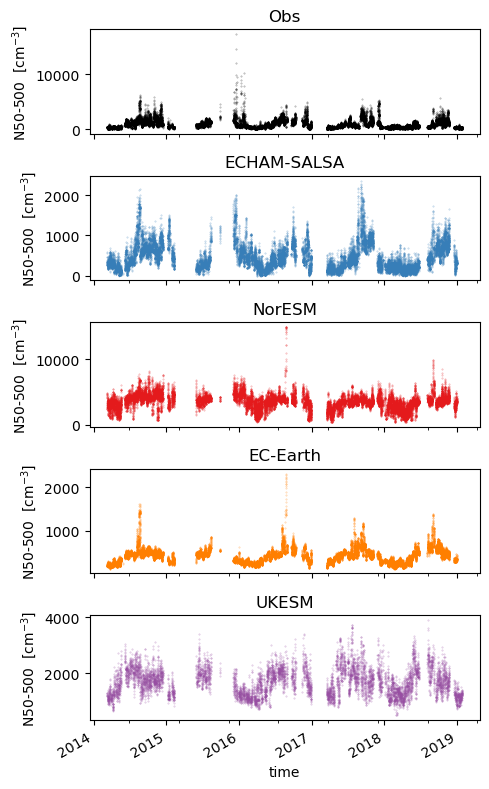

Plots/ATTO/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N50-500_timeseries_JA_ATTO.png


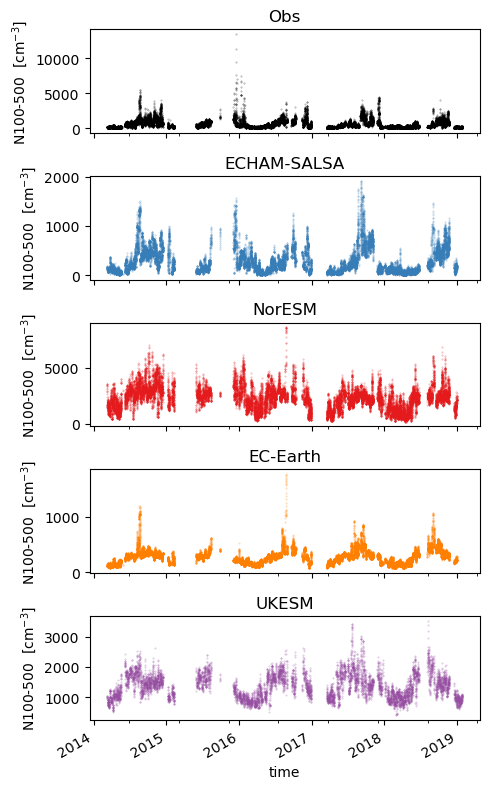

Plots/ATTO/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N100-500_timeseries_JA_ATTO.png


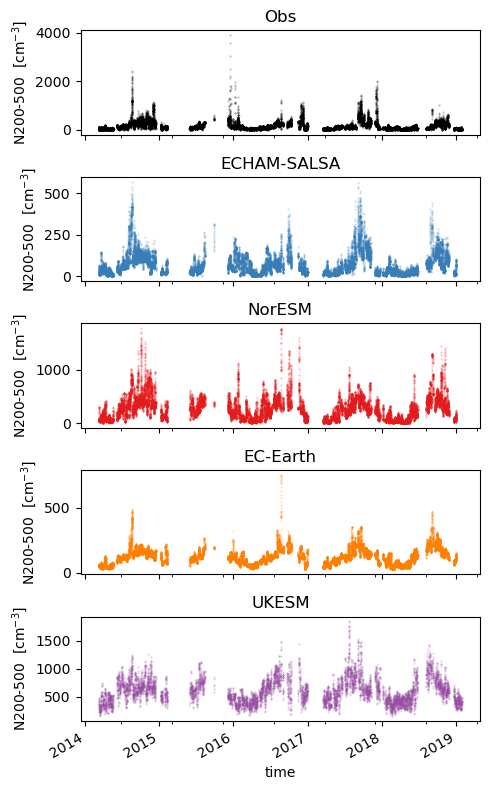

Plots/ATTO/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_N200-500_timeseries_JA_ATTO.png


In [37]:
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

seas = 'JA'
for i, v in enumerate(['N50-500','N100-500','N200-500']):
    fig, axs = plt.subplots(5,1, sharex=True, figsize=[5,8], dpi=100)
    
    #axs_sub = axs[:,i]
    #df_anom_Nx = dic[v]
    df_Nx = dic_Nx[v]

    #_df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(season2month[seas])]
    for mo, ax in zip(df_Nx.columns, axs):
        if mo=='Obs':
            c = 'k'
        else:
            c=cdic_model[mo]
            #continue
        ls = linestyle_dic[mo]
        _df = df_Nx[mo].copy()
        #_df_gbm = _df_gb.median()
        #_df_gbstd = _df_gb.std()
        #_df_gb33 = _df_gb.quantile(.84)
        #_df_gb66 = _df_gb.quantile(.16)
        
        _df.plot(ax=ax,c=c,
             #linestyle=ls,
             marker='.', 
             linewidth=0,
             markersize=.7,
             alpha=.4,
                 
             rasterized=True,
                 
             label=mo)
 
        ax.set_title(mo) 
        ax.set_ylabel('%s  [cm$^{-3}$]'%v)


        #ax.legend(frameon=False)

    #ax.set_xlabel('Time of day [h]')
    plt.tight_layout()
    plt.show()
    fn = make_fn_eval('_'.join(models), f'{v}_timeseries_{seas}')
    print(fn)

    #fig.savefig(fn.with_suffix('.png'))
    fig.savefig(fn.with_suffix('.pdf'))

## Choose months: 

In [38]:
df_Nx_all

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2014-03-10 15:00:00,123.407339,58.324501,197.265366,66.405383,NaN
2014-03-10 16:00:00,102.265441,63.565973,213.308267,65.207469,NaN
2014-03-10 17:00:00,104.508354,66.484084,236.811389,64.115330,374.762678
2014-03-10 18:00:00,120.456843,64.965436,269.511253,63.003068,NaN
2014-03-10 19:00:00,116.970997,62.657879,291.848602,61.902831,NaN
...,...,...,...,...,...
2019-01-28 05:00:00,1.160755,NaN,NaN,NaN,474.492033
2019-01-28 06:00:00,1.267096,NaN,NaN,NaN,NaN
2019-01-28 07:00:00,0.938360,NaN,NaN,NaN,NaN


In [39]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

Plots/ATTO/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_Nx_diurnal_mean_dev_MAM_ATTO.png


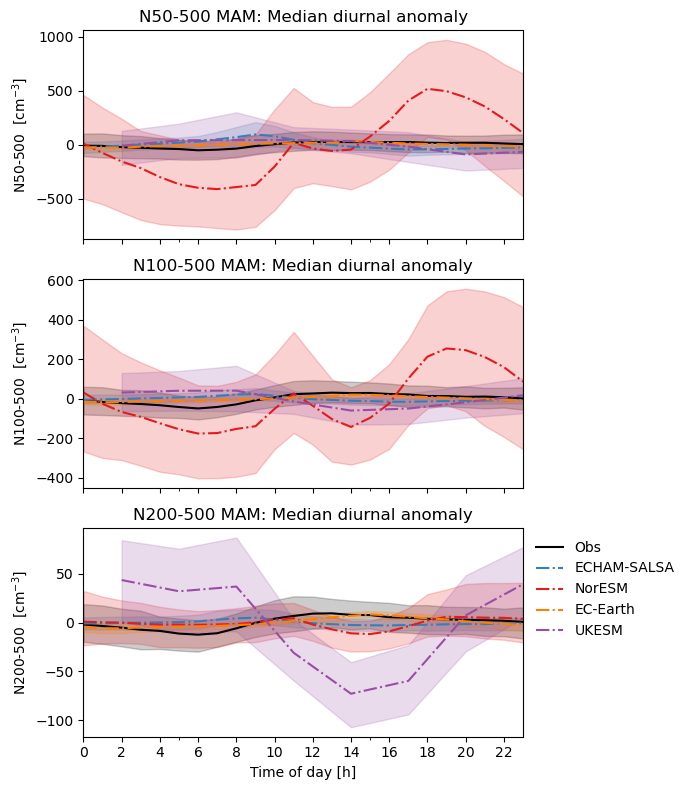

In [40]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

seas = 'MAM'
for v, ax in zip(varl_Nx, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(season2month[seas])].copy()
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{v} {seas}: Median diurnal anomaly") 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'Nx_diurnal_mean_dev_{seas}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

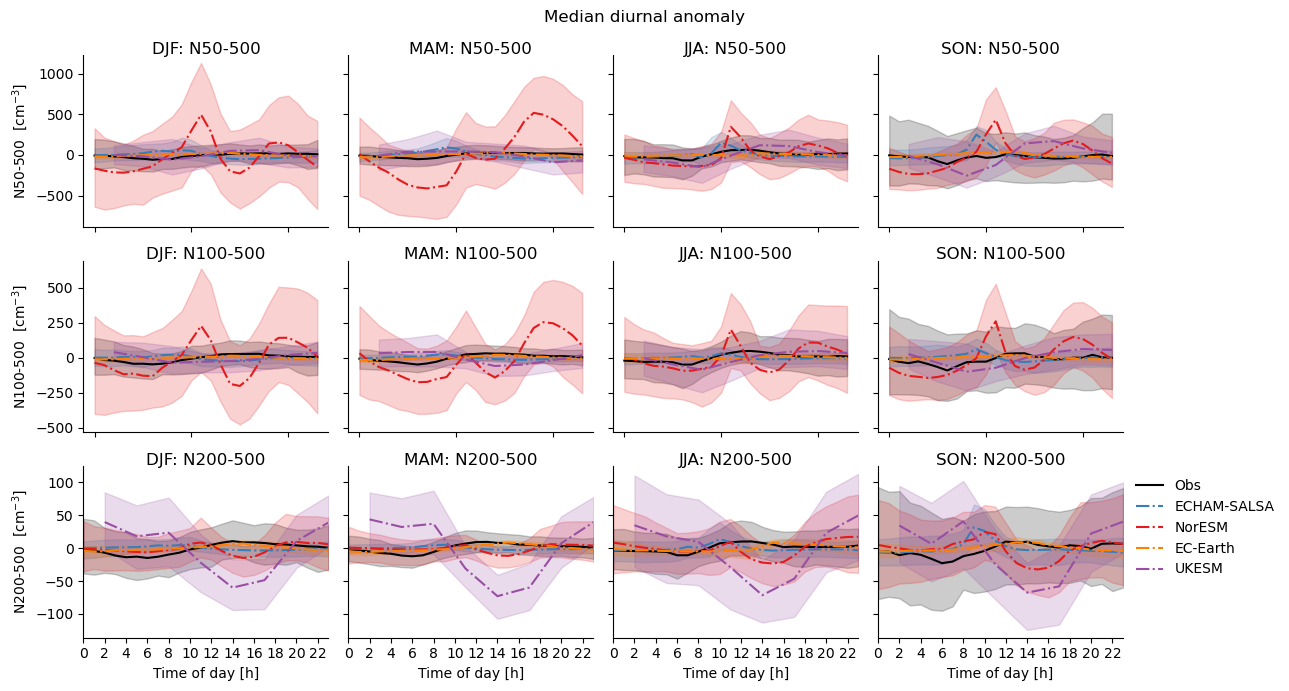

In [41]:
fig, axs_all = plt.subplots(3,4,  figsize=[13,7], dpi=100, sharey='row', sharex='row')
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N50-500'
for i,v in enumerate(varl_Nx):
    axs = axs_all[i,:]
    for seas, ax in zip(seasons2months, axs):
        df_anom_Nx = dic_anom_Nx[v]
        _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])].copy()
        for mod in df_anom_Nx.columns:
            if mod=='Obs':
                c = 'k'
            else:
                c=cdic_model[mod]
                #continue
            if mod=='UKESM':
                # 3h resolution so need to drop nans
                _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

            ls = linestyle_dic[mod]
            _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
            _df_gbm = _df_gb.median()
            _df_gbstd = _df_gb.std()
            _df_gb33 = _df_gb.quantile(.84)
            _df_gb66 = _df_gb.quantile(.16)
        
        
            _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
            ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
            # ax.set_title("$OA'$: Average diurnal anomaly") 
        ax.set_title(f'{seas}: {v}', y=.96)
        ax.set_xlabel('Time of day [h]')
    axs[0].set_ylabel('%s  [cm$^{-3}$]'%v)
    
fig.suptitle(f"Median diurnal anomaly") 


plt.legend(frameon=False, bbox_to_anchor = (1,1,) )
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'Nx_diurnal_mean_dev_seas')
sns.despine(fig)
fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

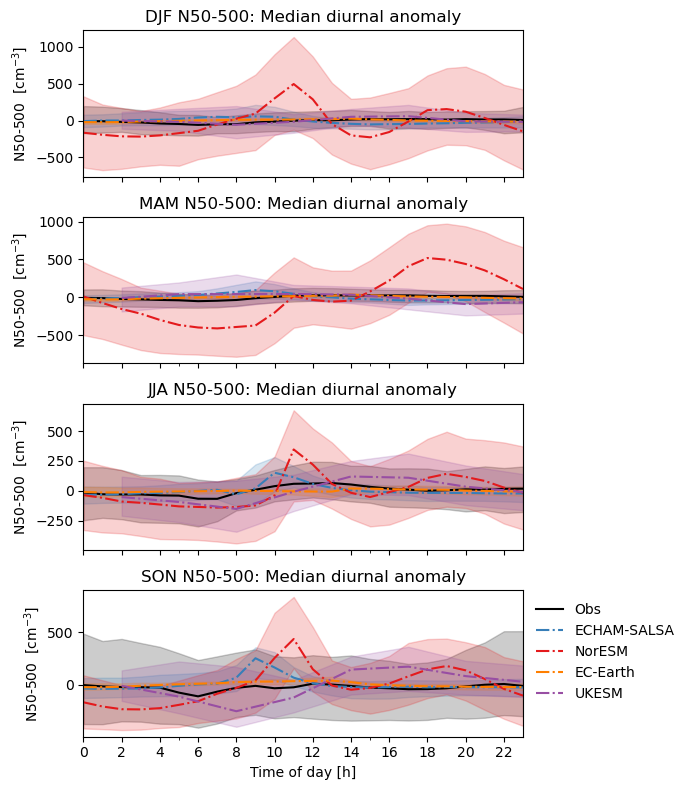

In [42]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N50-500'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])].copy()
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        ls = linestyle_dic[mod]
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    #ax.set_ylim([-.7,.7])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

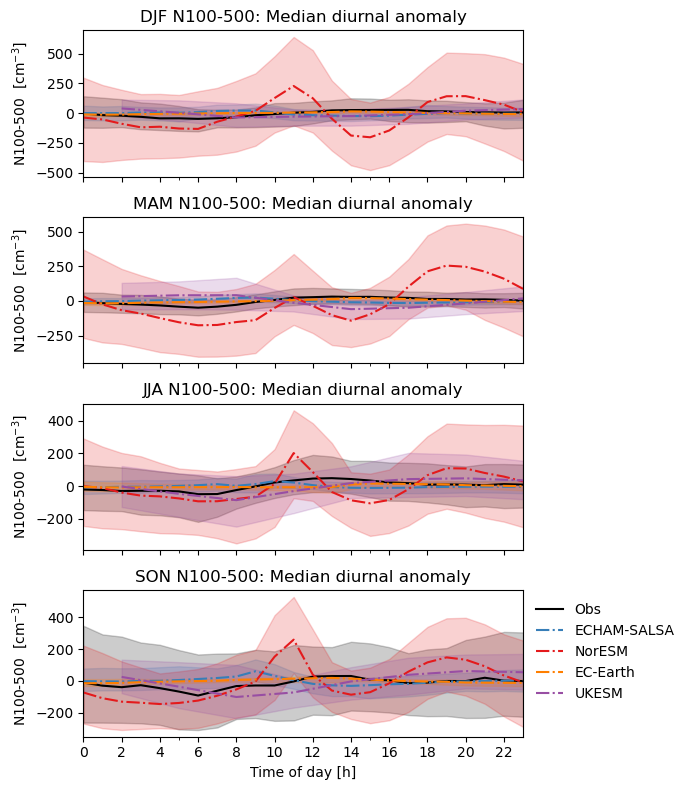

In [43]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N100-500'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continu
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    #ax.set_ylim([-.7,.7])

ax.legend(frameon=False)


plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

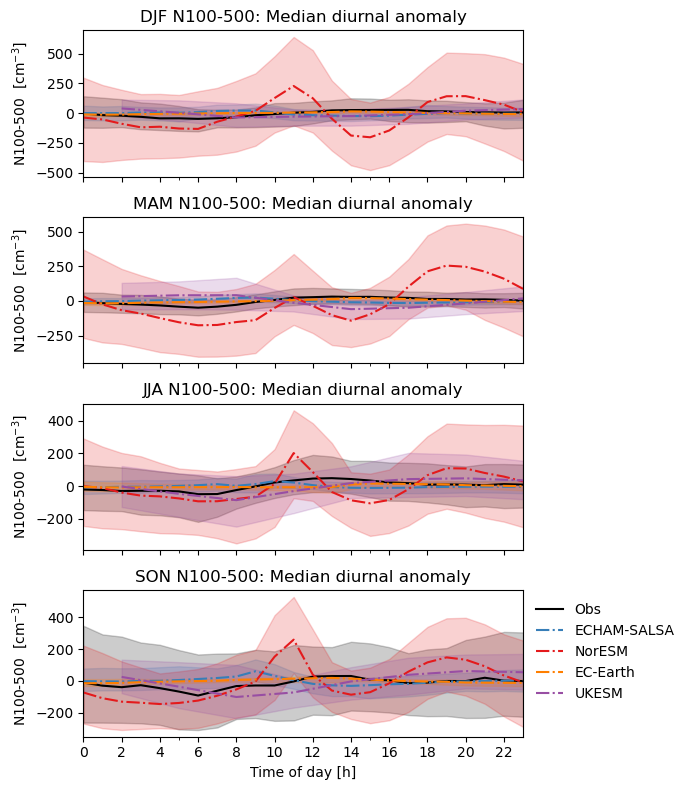

In [44]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N100-500'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    #ax.set_ylim([-.7,.7])

ax.legend(frameon=False)


plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

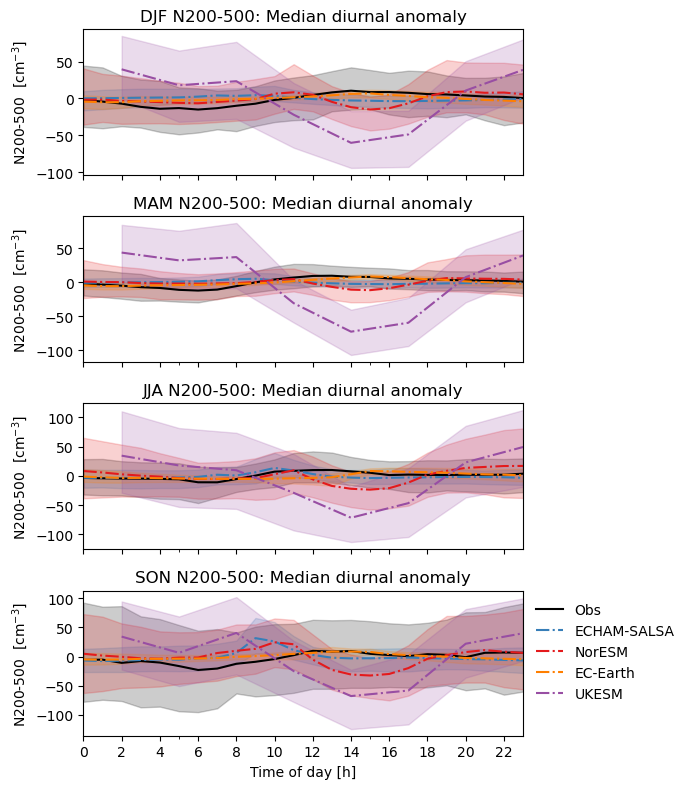

In [45]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N200-500'

for seas, ax in zip(seasons2months, axs):
    df_anom_Nx = dic_anom_Nx[v]
    _df_anom_Nx = df_anom_Nx[df_anom_Nx.index.month.isin(seasons2months[seas])]
    for mod in df_anom_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_anom_Nx = _df_anom_Nx[_df_anom_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_Nx[mod].groupby(_df_anom_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal anomaly") 

    #ax.set_ylim([-.7,.7])

ax.legend(frameon=False)


plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'{v}_diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

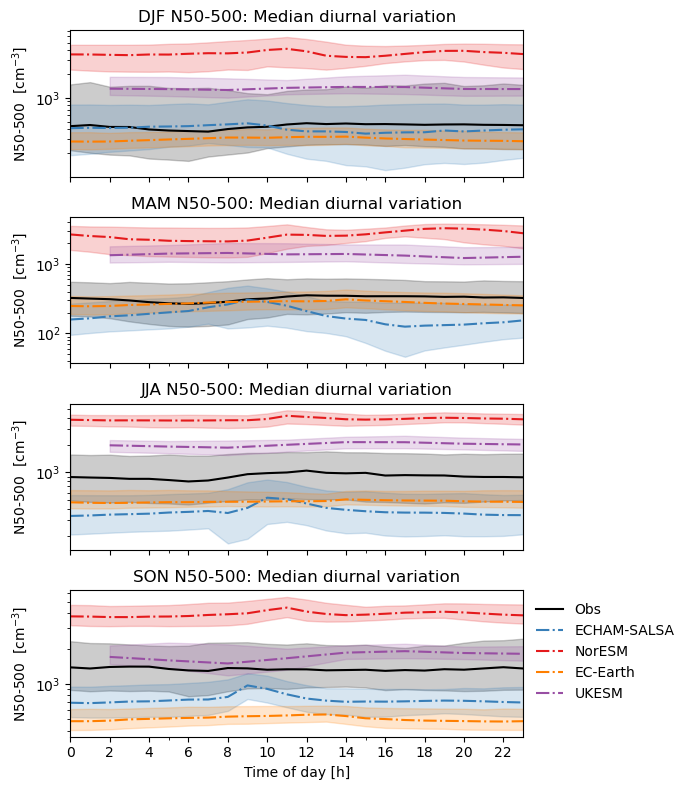

In [46]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N50-500'

for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
   
    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]
        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 
    ax.set_yscale('log')

    #ax.set_ylim([-3,3])

ax.legend(frameon=False)


plt.legend(frameon=False, bbox_to_anchor=(1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

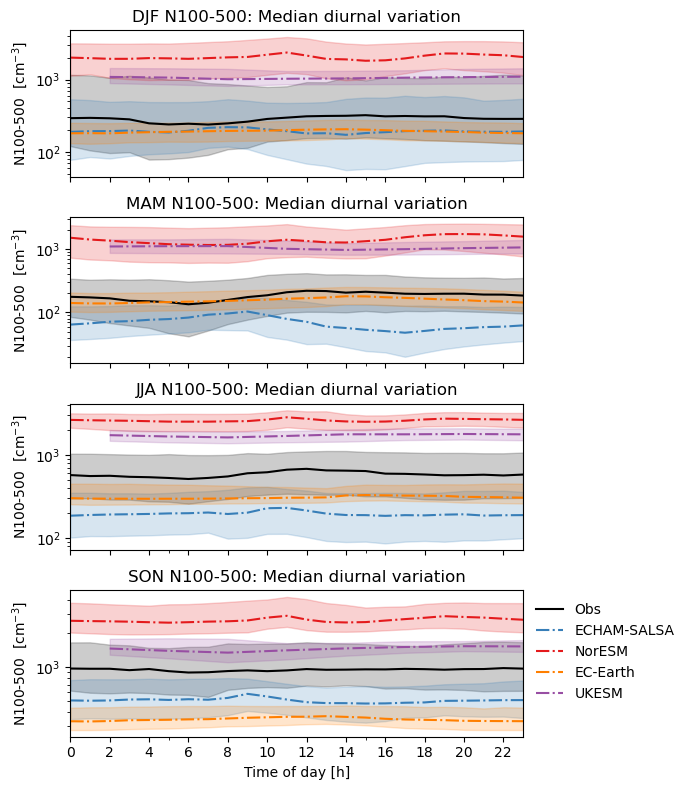

In [47]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

v = 'N100-500'

for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])]
    
    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 
    ax.set_yscale('log')

    #ax.set_ylim([-3,3])



plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

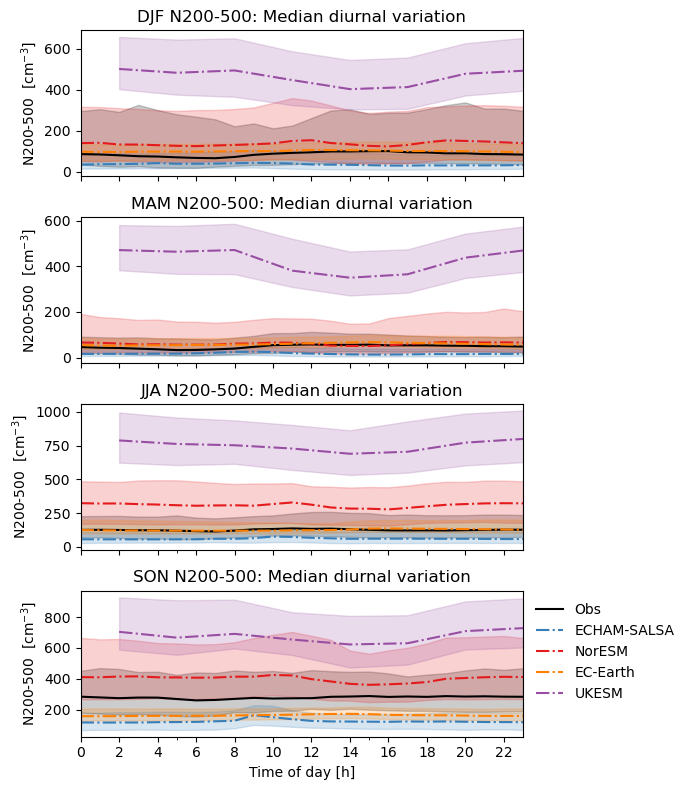

In [48]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')
v = 'N200-500'
for seas, ax in zip(seasons2months, axs):
    df_Nx = dic_Nx[v]
    _df_Nx = df_Nx[df_Nx.index.month.isin(seasons2months[seas])]

    
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod=='UKESM':
            # 3h resolution so need to drop nans
            _df_Nx = _df_Nx[_df_Nx[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                     linestyle=ls,
                     label=mod,
                    )
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} {v}: Median diurnal variation") 

    #ax.set_ylim([-3,3])


plt.legend(frameon=False, bbox_to_anchor = (1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)
plt.tight_layout()

#for ax in axs: 
#    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), f'diurnal_mean_{v}')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

Plots/ATTO/evalNx_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_annual_median_Nx_ATTO.png


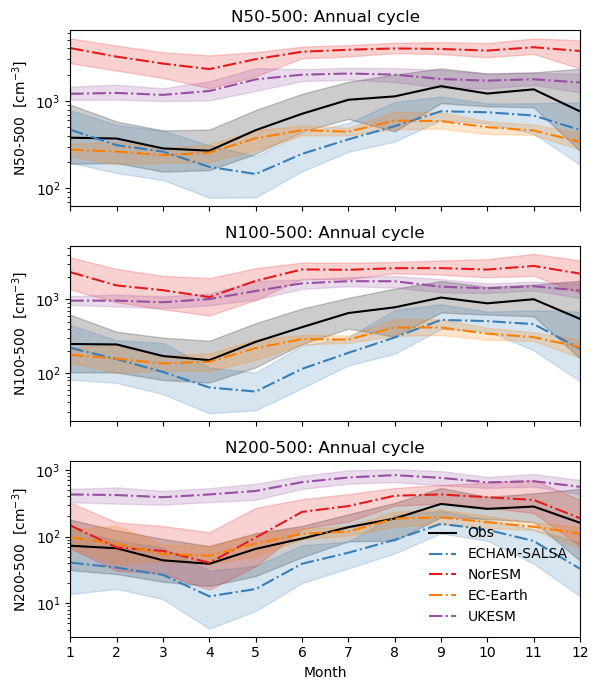

In [49]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=[6,7], dpi=100)
for v,ax in zip(varl_Nx, axs):  
    _df_Nx = dic_Nx[v]
    for mod in df_Nx.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
    
        ls = linestyle_dic[mod]
        _df_gb = _df_Nx[mod].groupby(_df_Nx.index.month)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
    
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
        # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{v}: Annual cycle") 
    ax.set_ylabel('%s  [cm$^{-3}$]'%v)

    ax.set_yscale('log')

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Month')
#ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'annual_median_Nx')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

In [50]:
import matplotlib as mpl

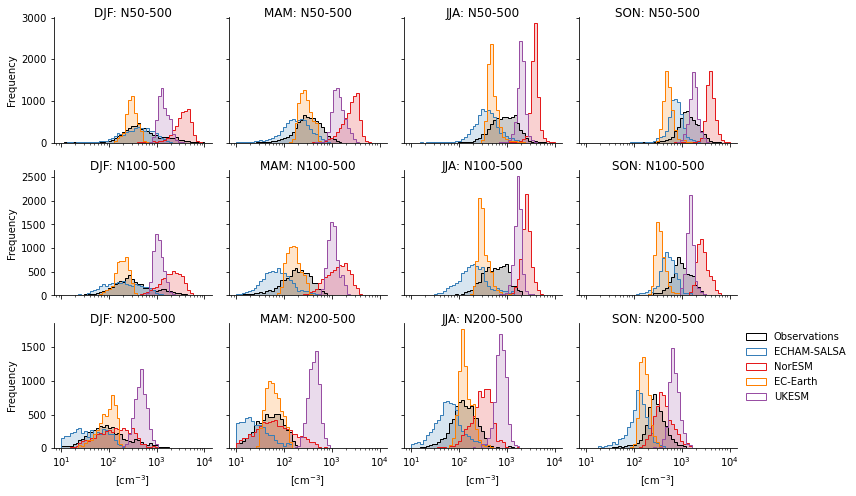

In [51]:
fig, axs_all = plt.subplots(3,4,figsize = [12,7,],sharex=True, sharey='row')

mi = 10#np.min(df_Nx[df_Nx['Obs']>0]['Obs'])*300
ma = 1e4#np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

v = 'N50-500'
for i, v in enumerate(['N50-500','N100-500','N200-500']):
    df_Nx = dic_Nx[v]
    axs = axs_all[i,:]




    for seas,ax in zip(seasons2months, axs.flatten()):
        df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months[seas])].copy()
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                    )
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax
                                    )

        for mo in models:
            if mo=='UKESM':
                # only 3 hourly resolution
                df_Nx_sub.loc[:,mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)

            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )

        ax.set_xscale('log')
        #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')
        ax.set_xlabel('[cm$^{-3}$]')

        # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

        ax.set_title(f'{seas}: {v}', y=.95)

ax.legend(frameon=False, bbox_to_anchor = (1,1,))
#plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons',f'hist_seas_Nx')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

In [52]:
seasons2months2={
    'JFM': [1, 2, 3],
    'MJJ': [5,6,7],
    'JA': [7,8],
    'SON': [9,10,11],
}

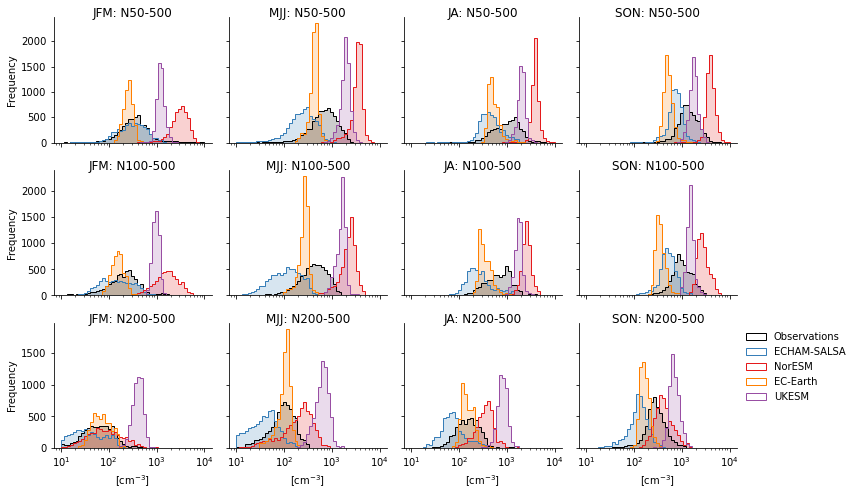

In [53]:
fig, axs_all = plt.subplots(3,4,figsize = [12,7,],sharex=True, sharey='row')

mi = 10#np.min(df_Nx[df_Nx['Obs']>0]['Obs'])*300
ma = 1e4#np.max(df_Nx[df_Nx['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

v = 'N50-500'
for i, v in enumerate(['N50-500','N100-500','N200-500']):
    df_Nx = dic_Nx[v]
    axs = axs_all[i,:]




    for seas,ax in zip(seasons2months2, axs.flatten()):
        df_Nx_sub = df_Nx[df_Nx.index.month.isin(seasons2months2[seas])].copy()
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                    )
        df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax
                                    )
        for mo in models:
            if mo=='UKESM':
                # only 3 hourly resolution
                df_Nx_sub.loc[:,mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)

            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
            df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
        ax.set_xscale('log')
        #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')
        ax.set_xlabel('[cm$^{-3}$]')

        # ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

        ax.set_title(f'{seas}: {v}', y=.95)

ax.legend(frameon=False, bbox_to_anchor = (1,1,))
#plt.suptitle(f'Distribution of {v} at {select_station}')
fn = make_fn_eval('noresm_echam_seasons2',f'hist_seas_Nx')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

In [54]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

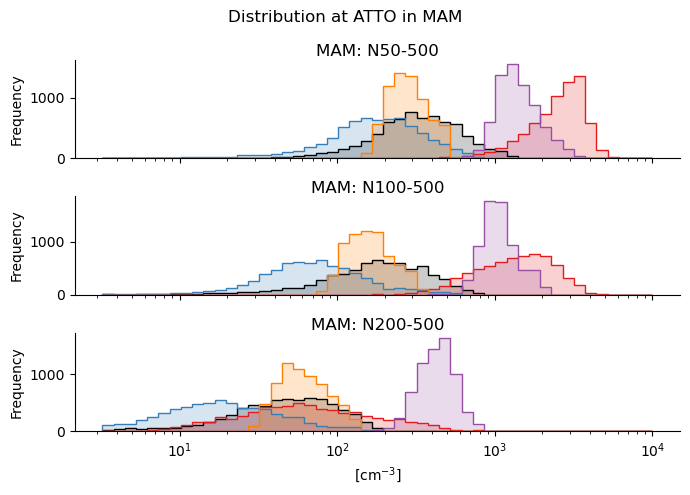

In [55]:
seas ='MAM'


mi = np.min(df_Nx[df_Nx['Obs']>0]['Obs'])*100
ma = 1e4
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)
v = 'N200'
fig, axs = plt.subplots(3,1,figsize = [7,5,],dpi=100, sharex=True)

for v, ax in zip(varl_Nx, axs):
    df_Nx = dic_Nx[v]

    df_Nx_sub = df_Nx[df_Nx.index.month.isin(season2month[seas])].copy()

    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                    )
    df_Nx_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax
                                    )
    for mo in models:
        if mo=='UKESM':
            # only 3 hourly resolution
            df_Nx_sub.loc[:,mo] =df_Nx_sub.loc[:,mo].ffill(limit=3)

        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label=mo,
                                histtype='step',
                                    )
        df_Nx_sub[mo].plot.hist(bins=bins_, alpha=.2, 
                                     color=cdic_model[mo],
                                    ax = ax,
                                     label='__nolabel__',
                                    )
    ax.set_xscale('log')
    ax.set_title(f'{seas}: {v}', y=.95)
ax.set_xlabel('[cm$^{-3}$]')
    
fig.suptitle(f'Distribution at {select_station} in {seas}')

fn = make_fn_eval('noresm_echam_JA','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


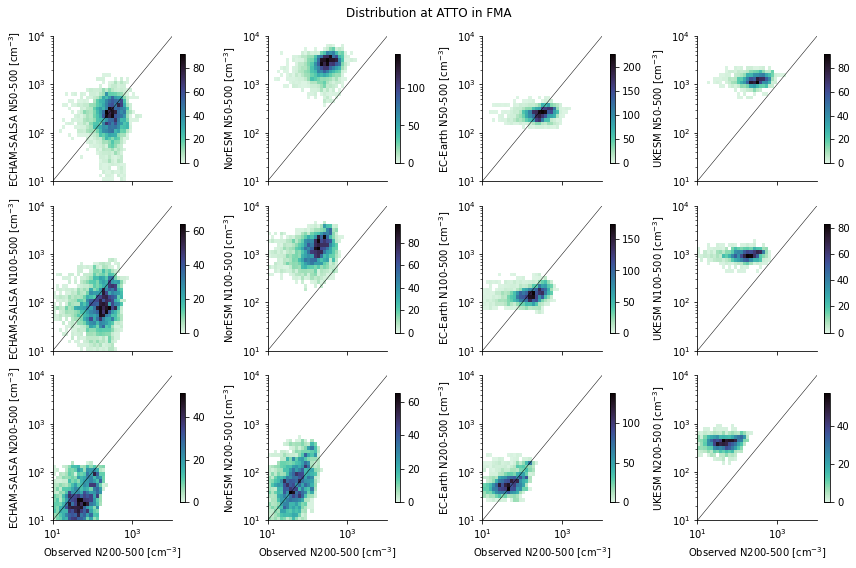

In [56]:
fig, axs = plt.subplots(3,4,figsize = [12,8],sharex=True, sharey=False)
seas = 'FMA'
for i, v in enumerate(varl_Nx):
    #v = 'N100'
    _df_Nx = dic_Nx[v]
    _df = _df_Nx[_df_Nx.index.month.isin(season2month[seas])].copy()
    _df['hour'] = _df.index.hour
    #_df = _df.resample('D').median()
    axs_sub = axs[i,:]
    bins = np.linspace(1,4,40)

    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e1,1e4])
        ax.set_xlim([1e1,1e4])
        ax.set_xscale('log')

        ax.set_ylabel(f'{mo} {v} '+'[cm$^{-3}$]')
        ax.set_xlabel(f'Observed {v} '+'[cm$^{-3}$]')



        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)
fig.suptitle(f'Distribution at {select_station} in {seas}')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{seas}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


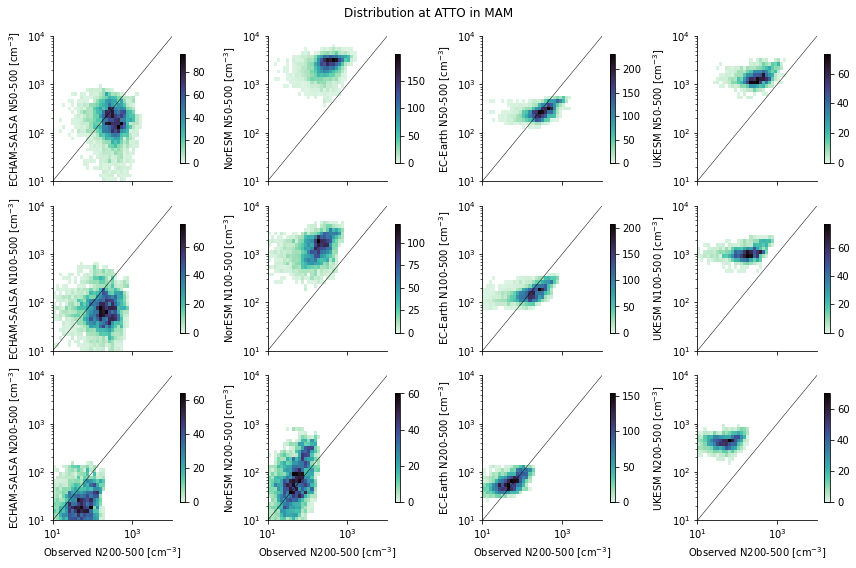

In [57]:
fig, axs = plt.subplots(3,4,figsize = [12,8],sharex=True, sharey=False)
seas = 'MAM'
for i, v in enumerate(varl_Nx):
    #v = 'N100'
    _df_Nx = dic_Nx[v]
    _df = _df_Nx[_df_Nx.index.month.isin(season2month[seas])].copy()
    _df['hour'] = _df.index.hour
    #_df = _df.resample('D').median()
    axs_sub = axs[i,:]
    bins = np.linspace(1,4,40)

    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e1,1e4])
        ax.set_xlim([1e1,1e4])
        ax.set_xscale('log')

        ax.set_ylabel(f'{mo} {v} '+'[cm$^{-3}$]')
        ax.set_xlabel(f'Observed {v} '+'[cm$^{-3}$]')



        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)
fig.suptitle(f'Distribution at {select_station} in {seas}')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{seas}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

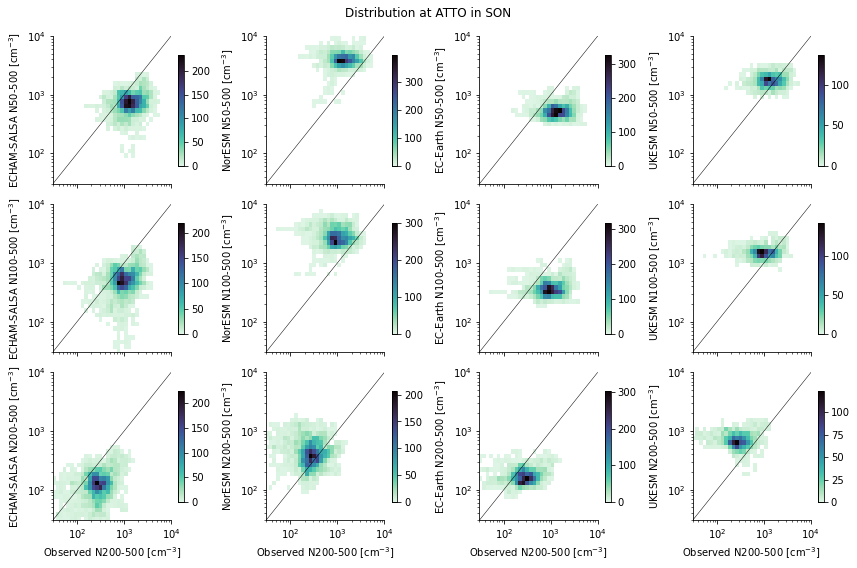

In [58]:
fig, axs = plt.subplots(3,4,figsize = [12,8],sharex=True, sharey=False)
seas = 'SON'
for i, v in enumerate(varl_Nx):
    #v = 'N100'
    _df_Nx = dic_Nx[v]
    _df = _df_Nx[_df_Nx.index.month.isin(season2month[seas])].copy()
    _df['hour'] = _df.index.hour
    #_df = _df.resample('D').median()
    
    axs_sub = axs[i,:]
    bins = np.linspace(1,4,40)

    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([3e1,1e4])
        ax.set_xlim([3e1,1e4])
        ax.set_xscale('log')

        ax.set_ylabel(f'{mo} {v} '+'[cm$^{-3}$]')
        ax.set_xlabel(f'Observed {v} '+'[cm$^{-3}$]')



        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)
fig.suptitle(f'Distribution at {select_station} in {seas}')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{seas}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

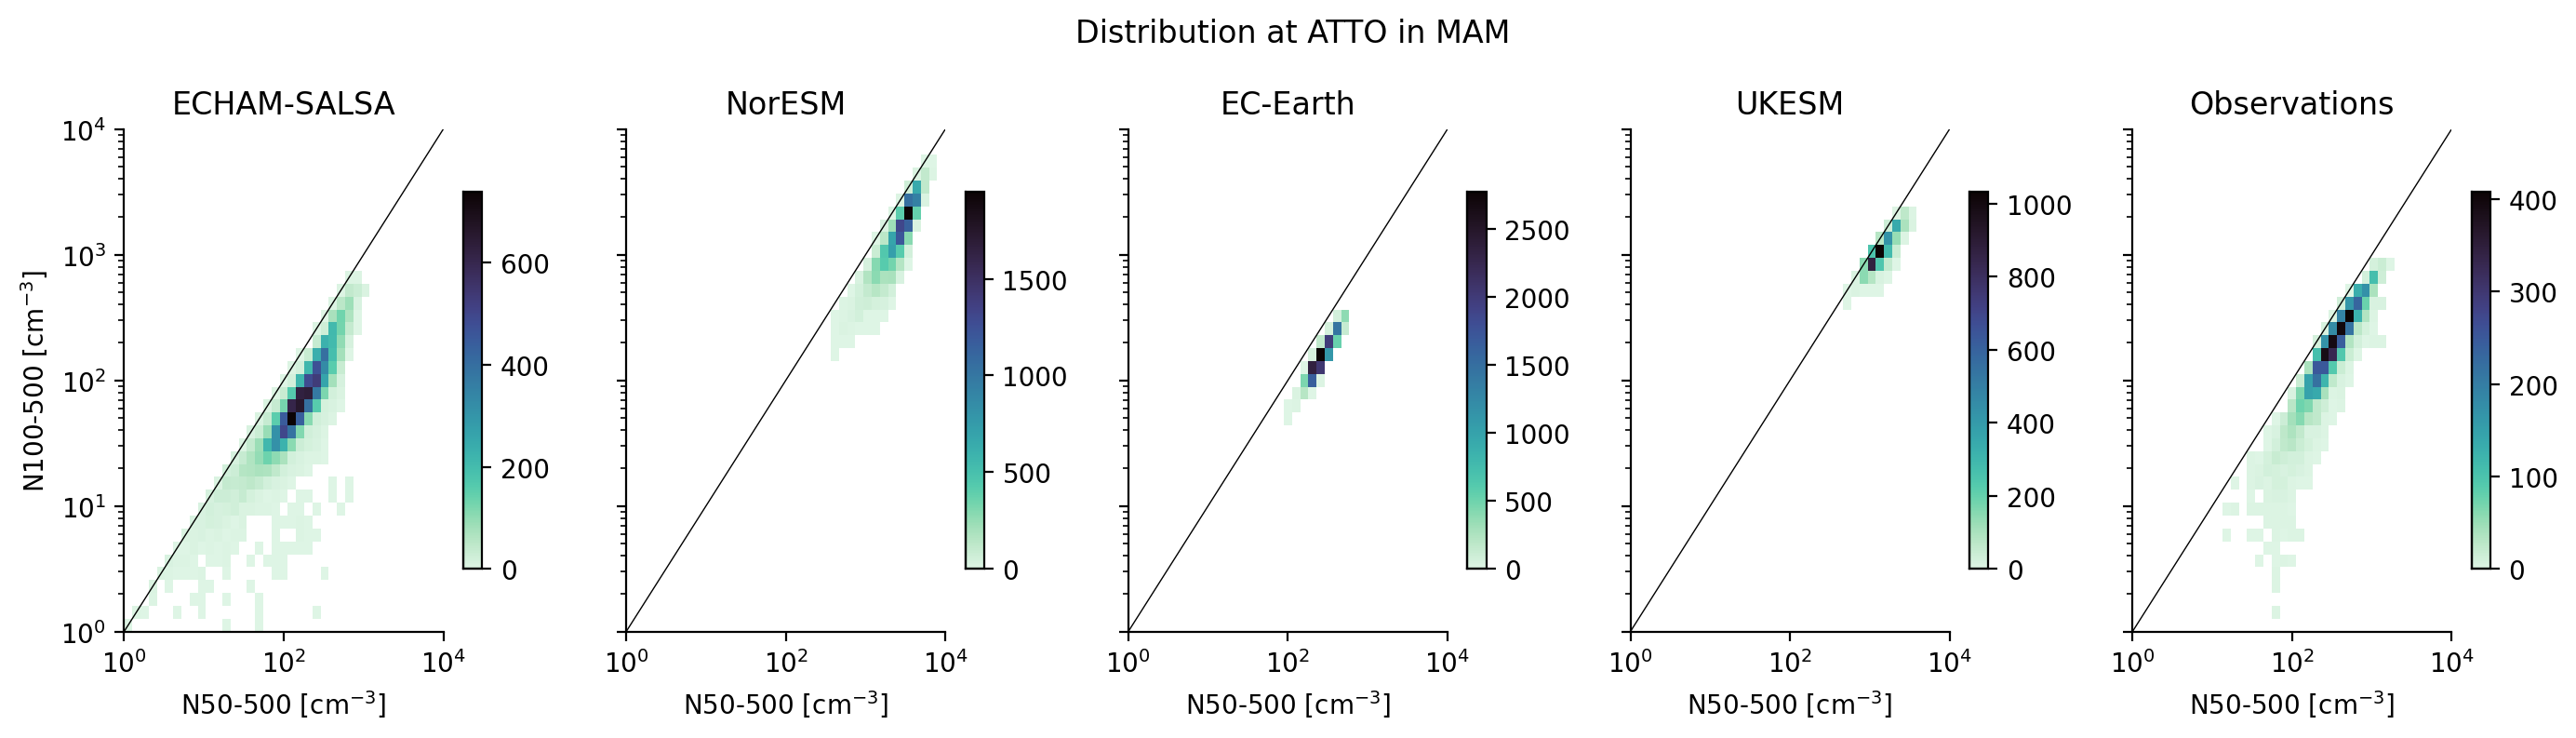

In [59]:
fig, axs = plt.subplots(1,5,figsize = [14,4],sharex=True, sharey=True, dpi=200)
seas = 'MAM'
vx = 'N50-500'
vy = 'N100-500'
for i, mo in enumerate(dic_df_mod_case.keys()):
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]]
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy()
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(0,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1,1e4])
    ax.set_xlim([1,1e4])
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
fig.suptitle(f'Distribution at ATTO in {seas}')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


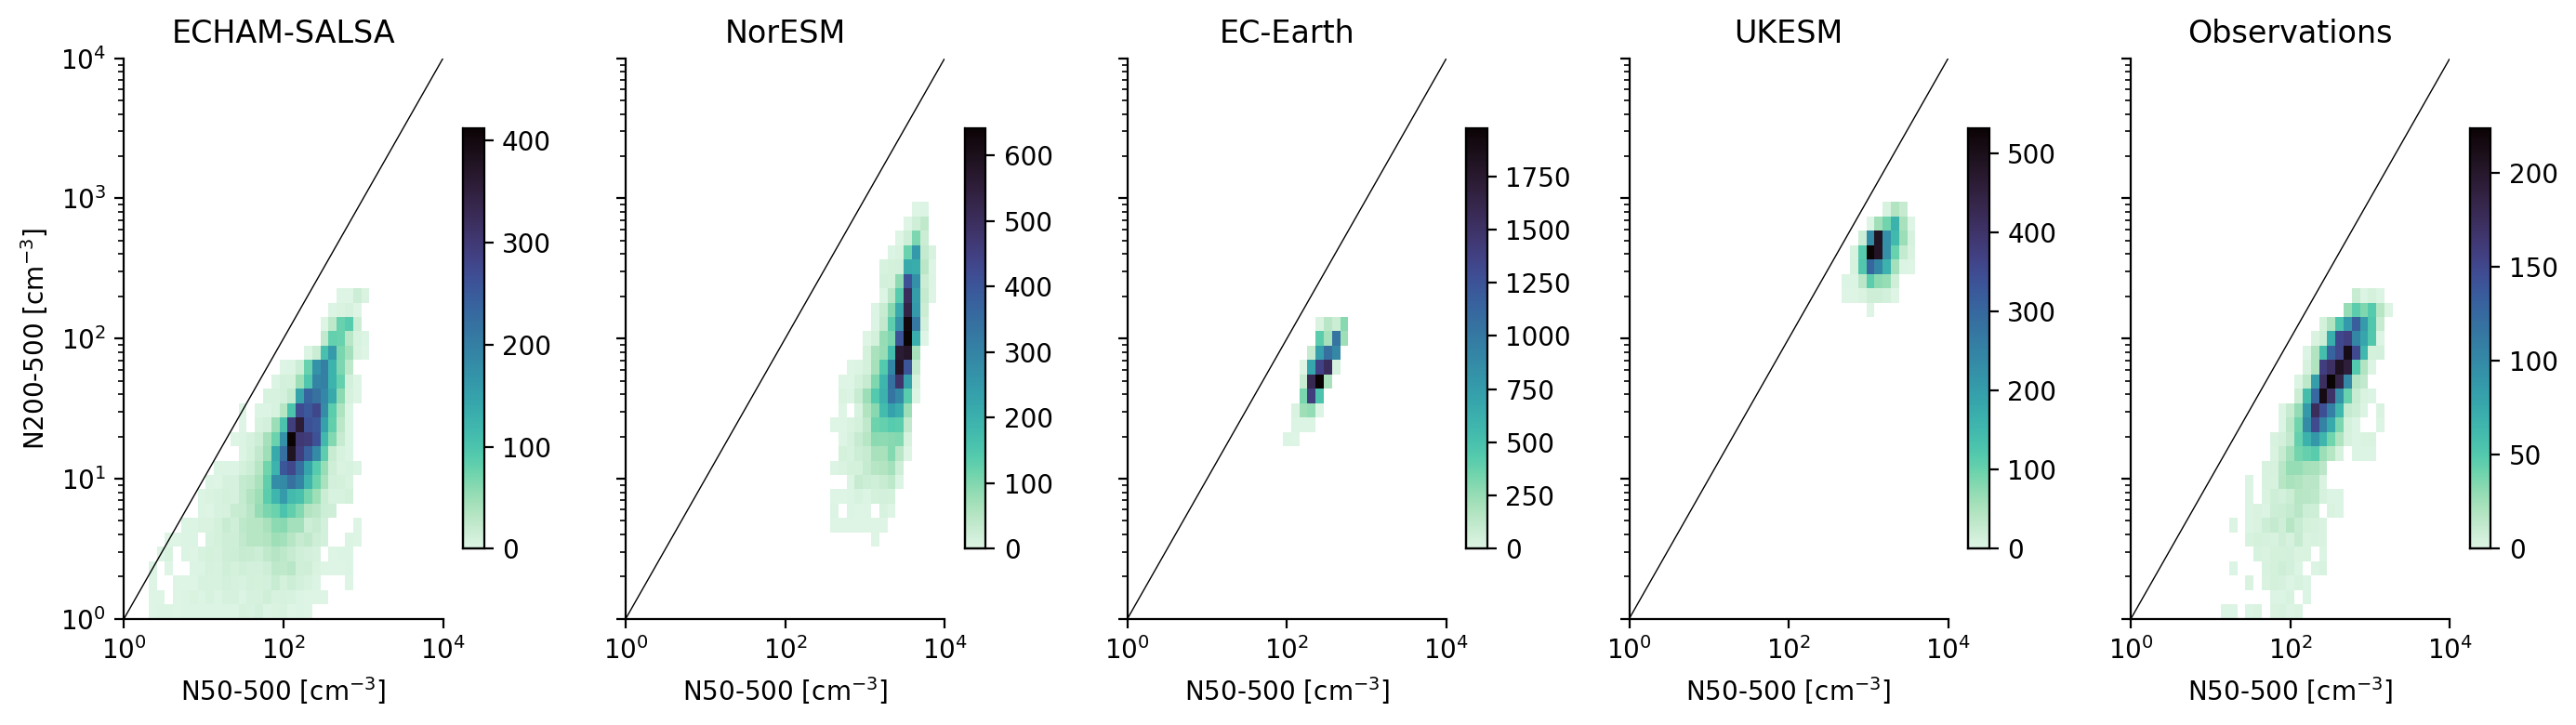

In [60]:
fig, axs = plt.subplots(1,5,figsize = [14,4],sharex=True, sharey=True, dpi=200)

seas = 'MAM'
vx = 'N50-500'
vy = 'N200-500'
for i, mo in enumerate(dic_df_mod_case.keys()):
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]]
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])]
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(0,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1,1e4])
    ax.set_xlim([1,1e4])

    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


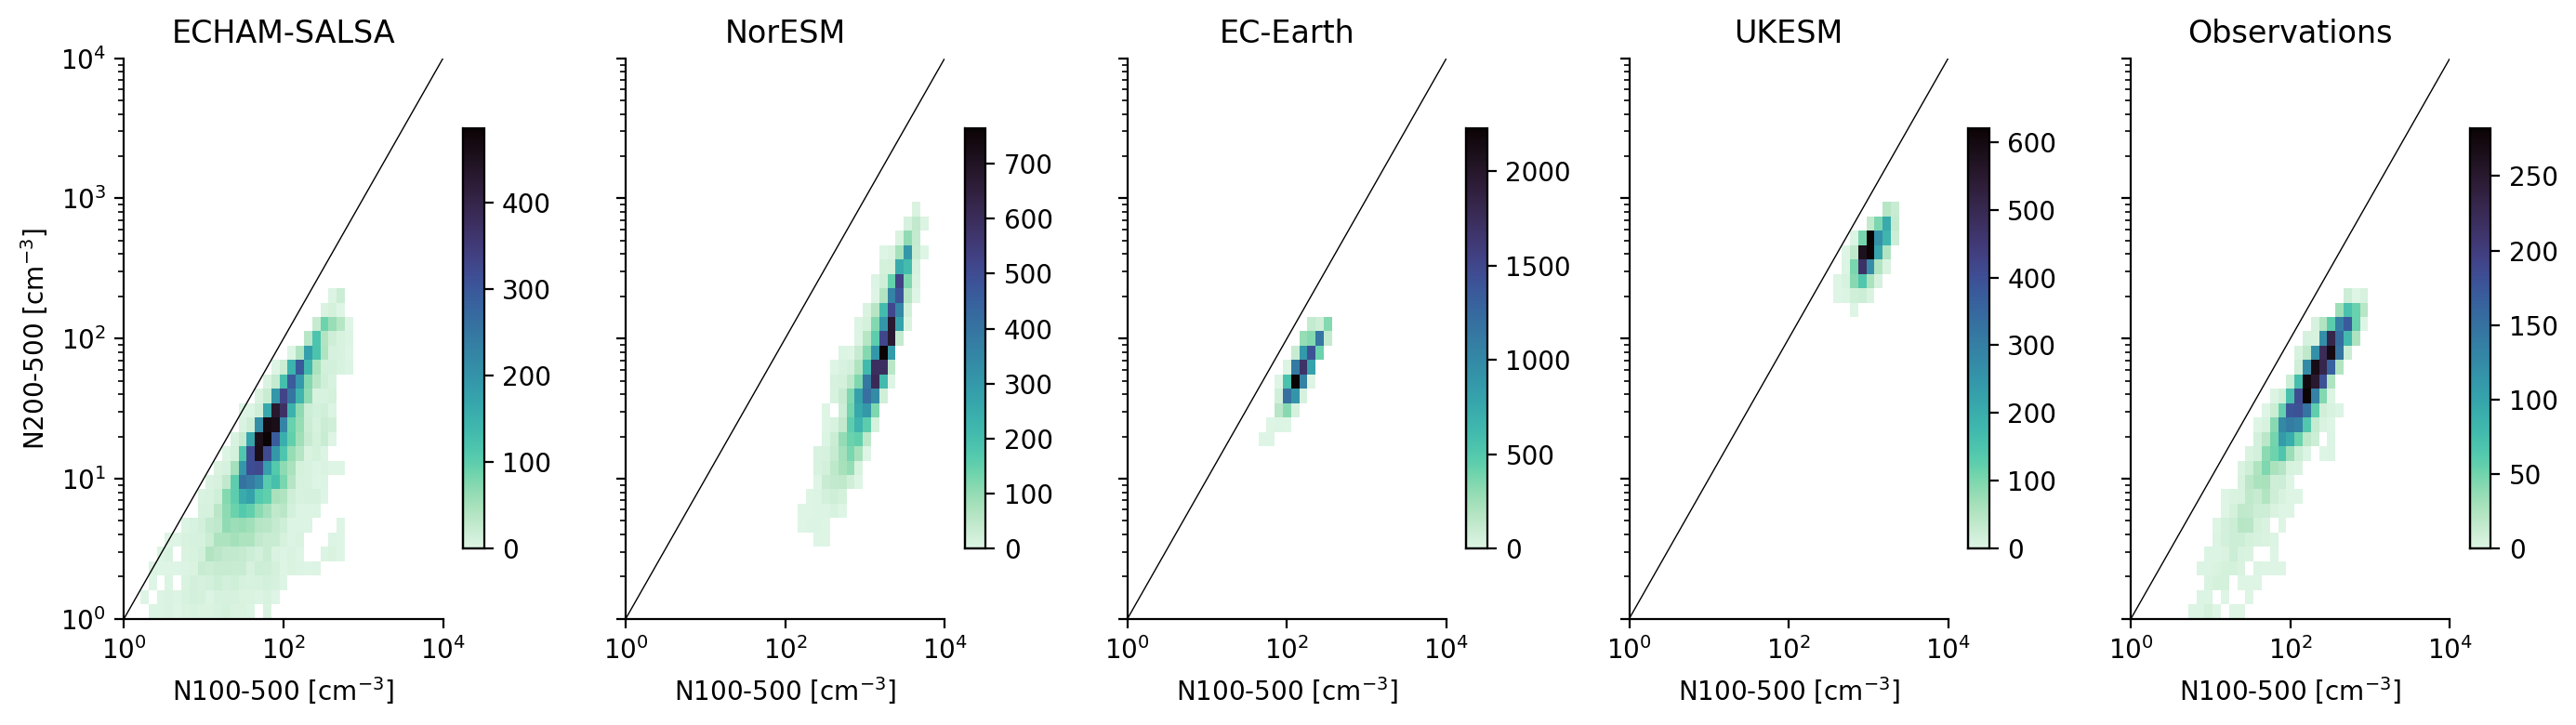

In [61]:
fig, axs = plt.subplots(1,5,figsize = [14,4],sharex=True, sharey=True, dpi=200)

seas = 'MAM'
vx = 'N100-500'
vy = 'N200-500'
for i, mo in enumerate(dic_df_mod_case.keys()):
    #v = 'N100'
    _df_mod = dic_df_mod_case[mo][mod2cases[mo][0]]
    _df = _df_mod[_df_mod.index.month.isin(season2month[seas])].copy()
    #_df['hour'] = _df.index.hour
    ax = axs[i]
    bins = np.linspace(0,4,40)

    #for mo, ax in zip(models,axs_sub):
    sns.histplot(y=vy, x=vx,#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e0,1e4])
    ax.set_xlim([1e0,1e4])
    
    ax.set_xscale('log')
    ax.set_ylabel(f'{vy} '+'[cm$^{-3}$]')
    ax.set_xlabel(f'{vx} '+'[cm$^{-3}$]')
    ax.set_title(mo)

    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)
#fig.suptitle(f'Distribution at {select_station} in July & August')
    

fn = make_fn_eval('_'.join(models),f'2dist_Nx_conc_{vx}_against_{vy}')
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'),)